## Understanding Libraries Used

If you are using the sagemaker, you need the boto3 library. Just like you use pandas to read data from your local system, boto3 helps us to access data from the S3 buckets if access to those buckets are provided

In [1]:
import sagemaker
import boto3
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import s3_input, Session

## Data Preparation & Importing to S3

The response variable that we are predicting for the dataset is “medv”, which is the median value of owner occupied home in thousands.

First we need to split our data into train and test then convert these into numpy arrays. We will need the data in this format to convert it to **RecordIO** later which is the format Linear Learner/SageMaker expects data for training.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('boston_data.csv')
df.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,black,lstat,medv
0,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
1,0.10328,25.0,5.13,0.0,0.453,5.927,47.2,6.9320,8.0,284.0,19.7,396.90,9.22,19.6
2,0.34940,0.0,9.90,0.0,0.544,5.972,76.7,3.1025,4.0,304.0,18.4,396.24,9.97,20.3
3,2.73397,0.0,19.58,0.0,0.871,5.597,94.9,1.5257,5.0,403.0,14.7,351.85,21.45,15.4
4,0.04337,21.0,5.64,0.0,0.439,6.115,63.0,6.8147,4.0,243.0,16.8,393.97,9.43,20.5


In [3]:
X = df.drop(['medv'], axis = 1)
y = df['medv']
#Convert to numpy arrays
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30)

Before we can convert our numpy arrays to **RecordIO** we need to make sure we can access our **S3 Bucket** and **IAM role** we created. We will be using these when we call Linear Learner to train on our data.

In [4]:
import sagemaker
import boto3

#Create a SageMaker session
sagemaker_session = sagemaker.Session()
bucket = "linlearner-housingdata-test"
prefix = "linear-learner" #prefix is a sub-folder/key within the S3 bucket

#Access SageMaker role created prior to session
#Need to pass role to training job
role = sagemaker.get_execution_role()
print(role)

arn:aws:iam::907658219813:role/service-role/AmazonSageMaker-ExecutionRole-20210715T232904


Now that we have our data in the proper format, we need to be able to upload the data to our S3 bucket. We create sub-folders for our train, test and model artifacts data (information after training job is done).


In [5]:
#Need to convert dataset to RecordIO format for Linear Learner to understand
import io 
import sagemaker.amazon.common as smac 
import os

buf = io.BytesIO()
smac.write_numpy_to_dense_tensor(buf, X_train, y_train)
buf.seek(0) 

###Uploading training data
#Filename for training data we are uploading to S3 
# Very important
key = 'linear-train-data'
#Upload training data to S3
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train', key)).upload_fileobj(buf)
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_train_data))

###Uploading test data
buf = io.BytesIO() # create an in-memory byte array (buf is a buffer I will be writing to)
smac.write_numpy_to_dense_tensor(buf, X_test, y_test)
buf.seek(0)

#Sub-folder for test data
key = 'linear-test-data'
boto3.resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test', key)).upload_fileobj(buf)
s3_test_data = 's3://{}/{}/test/{}'.format(bucket, prefix, key)
print('uploaded training data location: {}'.format(s3_test_data))

###Model Artifacts
output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(output_location))

uploaded training data location: s3://linlearner-housingdata-test/linear-learner/train/linear-train-data
uploaded training data location: s3://linlearner-housingdata-test/linear-learner/test/linear-test-data
Training artifacts will be uploaded to: s3://linlearner-housingdata-test/linear-learner/output


### You should now have your training and test data stored in your S3 bucket.

## Training & Understanding Linear Learner

Now that our data is properly configured, we can see the magic of Linear Learner. Linear Learner is one of AWS’s Supervised Learning algorithms and can be used for Regression and Classification problems. For classification it supports both Binary Classification and Multi-Class Classification. For our regression problem we also have a number of hyperparameters that we can provide the algorithm ranging from epochs to batch size. First we need to access the training container of Linear Learner.

In [6]:
from sagemaker.amazon.amazon_estimator import image_uris
container = image_uris.retrieve('linear-learner', boto3.Session().region_name)

linear = sagemaker.estimator.Estimator(container,
                                       role, 
                                       instance_count = 1, 
                                       instance_type = 'ml.c4.xlarge',
                                       output_path = output_location,
                                       sagemaker_session = sagemaker_session)

Note for the SageMaker estimator our output path is the S3 bucket path for model artifacts we have created. Now that we have created our estimator, we can set our hyperparameters. The most important hyperparameter in this case is feature_dim, which is the number of features we have in our X set that we are using to predict our response. For our dataset we have 13 features we are feeding to evaluate median house prices. For a list of all available hyperparameters click here.

In [7]:
linear.set_hyperparameters(feature_dim = 13,
                           predictor_type = 'regressor',
                           mini_batch_size = 20,
                           epochs = 5,
                           num_models = 10,
                           loss = 'absolute_loss')

In [8]:
#Pass in S3 training_data path variable we declared earlier
linear.fit({'train': s3_train_data})

2021-07-16 04:34:35 Starting - Starting the training job...
2021-07-16 04:34:37 Starting - Launching requested ML instancesProfilerReport-1626410075: InProgress
...
2021-07-16 04:35:30 Starting - Preparing the instances for training............
2021-07-16 04:37:31 Downloading - Downloading input data
2021-07-16 04:37:31 Training - Downloading the training image...
2021-07-16 04:38:02 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
[07/16/2021 04:37:56 INFO 139730002769728] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale

## Endpoint Creation & Model Evaluation

In [10]:
linear_regressor = linear.deploy(initial_instance_count = 1,
                                          instance_type = 'ml.m4.xlarge')

#need to make sure data is in correct format for deployed model
from sagemaker.predictor import csv_serializer, json_deserializer
linear_regressor.serializer = csv_serializer
linear_regressor.deserializer = json_deserializer

-------------!

Note that we’ve also serialized our model to make sure we can process our results and compare it to the actual Y test results. After your endpoint has been successfully created you should see an exclamation message and an endpoint will appear when you check active Endpoints on the SageMaker service.

The csv_serializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


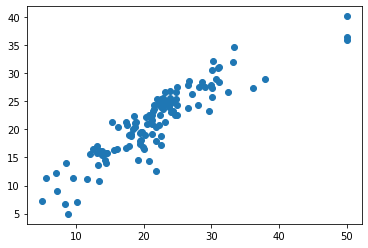

In [11]:
result = linear_regressor.predict(X_test)
result #should be a JSON

#Iterate the result JSON to get an NP array of all the predictions so we can compare to Y test
predictions = np.array([res['score'] for res in result['predictions']])
predictions #should now be an numpy array

#Visualize how accurate predictions are relative to y_test
plt.scatter(y_test, predictions)

We can see our model was pretty accurate overall, but let’s use Root Mean-Squared Error (RMSE) to evaluate our model numerically.

In [12]:
from sklearn import metrics 
np.sqrt(metrics.mean_squared_error(y_test, predictions))

3.479302979413433